In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from pi_py_darknet.darknet import initialize, detect
import cv2
from IPython.display import Image, display

In [3]:
from picamera import PiCamera
import time

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt


In [5]:
net, meta = initialize()

Initializing Darknet
--Done!


In [6]:
camera = PiCamera()
camera.rotation = 180
camera.resolution = (640, 480)
time.sleep(2)

In [7]:
def detect_people(img_filename):
#     results = darknet.detect(net, meta, b"foo.jpg")
    results = detect(net, meta, bytes(img_filename, 'utf-8'))
    
    people = []
    
    for cat, score, bounds in results:
        if cat == 'person':
            people.append((cat, score, bounds))
            
    return people



In [8]:
%load_ext line_profiler

In [12]:
def run():
    n = 0
    predictions = []
    while n < 5:

        img_filename = 'capture.jpg'
        camera.capture(img_filename)

        img = cv2.imread(img_filename)

#         ax1.imshow(img)
#         fig.canvas.draw()

        people = detect_people(img_filename)

        for cat, score, bounds in people:
            x, y, w, h = bounds
            print(x, y, w, h)
            
            cv2.rectangle(img, (int(x - w / 2), int(y - h / 2)), (int(x + w / 2), int(y + h / 2)), (255, 0, 0), thickness=2)
            cv2.circle(img, (x, y))
            label = '{}:{:06.3f}'.format(str(cat.decode("utf-8")), score*100)
            cv2.putText(img,label,(int(x),int(y)),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,0))

        out_file = 'results/predicted_{}.png'.format(n)
        cv2.imwrite(out_file, img)
        predictions.append(people)
        
        display(Image(filename=out_file, width=640, height=480))
        
        print(n, len(people))

        n += 1

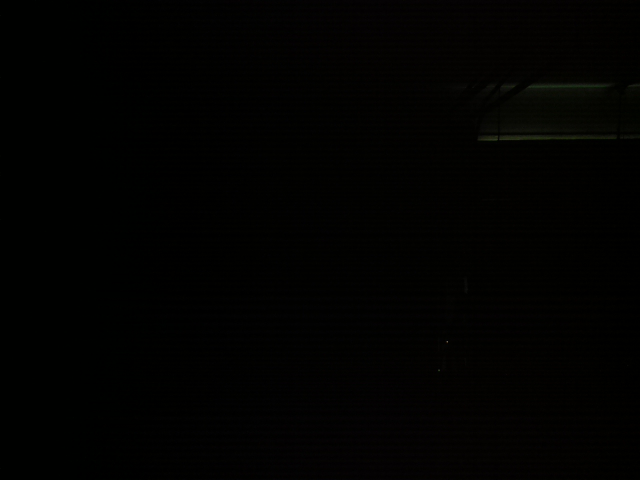

0 0


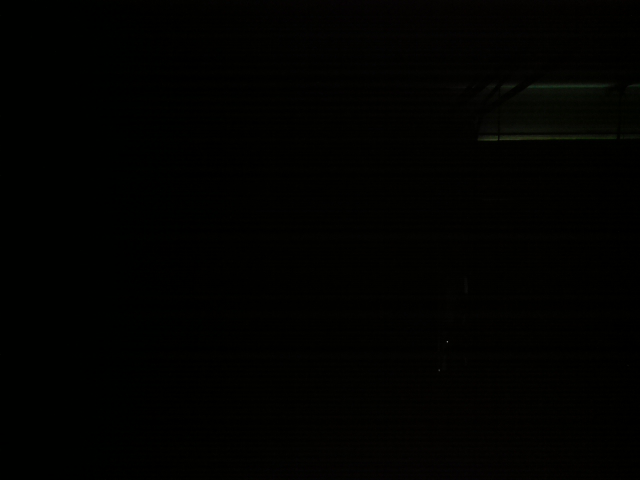

1 0


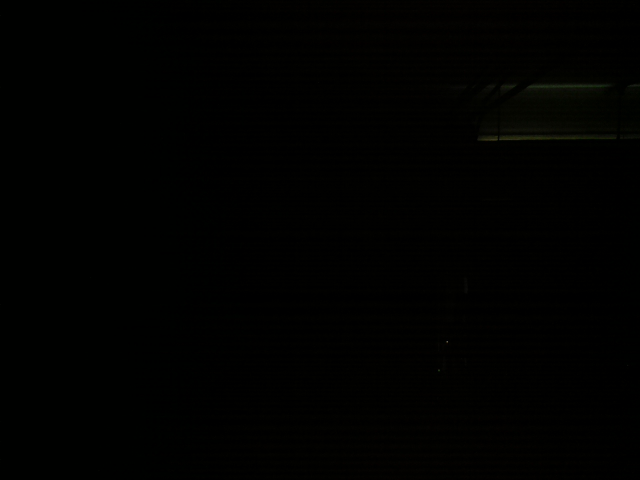

2 0


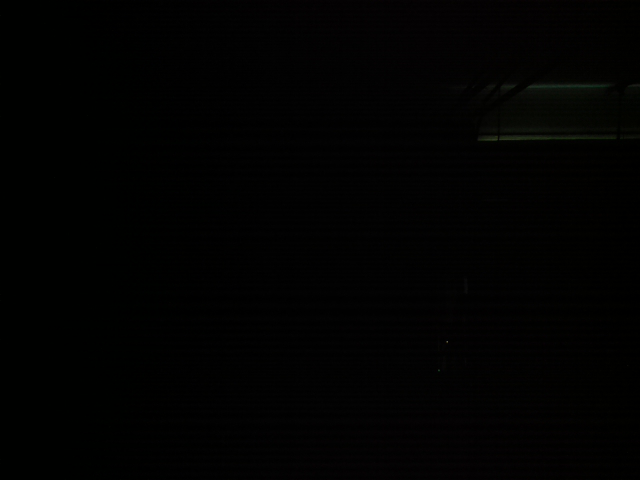

3 0


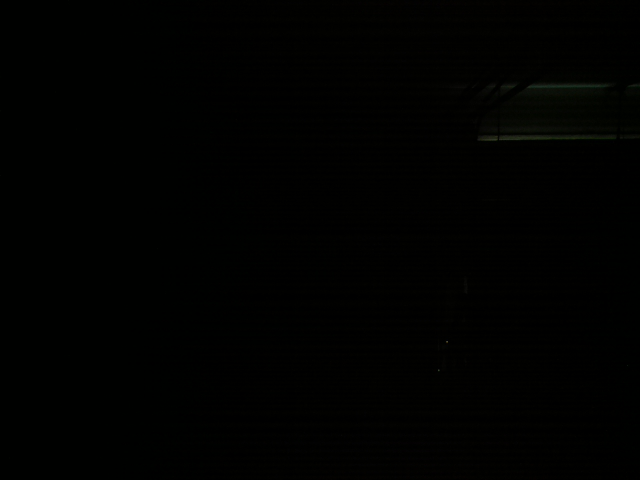

4 0


In [13]:
run()

In [17]:
%lprun -f run run()

0 0
1 0
2 0
